In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torchtext.vocab as vocab
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [ ]:
# Install the Kaggle API package
%pip install kaggle

# Upload your Kaggle API key (you should have the kaggle.json file downloaded from Kaggle)
from google.colab import files
files.upload()  # Upload your Kaggle API key

# Create a directory for the Kaggle API key
%mkdir ~/.kaggle
%cp kaggle.json ~/.kaggle/
%chmod 600 ~/.kaggle/kaggle.json

# Use the Kaggle API to download the dataset
%kaggle datasets download -d talha002/rottentomatoes-400k-review


In [3]:
# Unzip the dataset
!unzip rottentomatoes-400k-review.zip

Archive:  rottentomatoes-400k-review.zip
  inflating: rottentomatoes-400k.csv  


In [9]:
# is_cuda = torch.cuda.is_available()

# if is_cuda:
#     device = torch.device("cuda")
#     print("GPU is available")

# else:
#     device = torch.device("cpu")
#     print("GPU not available, CPU used")

device = torch.device('mps')

In [11]:
df = pd.read_csv("rottentomatoes-400k.csv")
df.head()

,Unnamed: 0,Movie,Reviewer,Publish,Review,Date,Score
0,0,HOTEL TRANSYLVANIA: TRANSFORMANIA,James Luxford,City AM,I guess its always been hard for me to see the...,03/03/2022,40.0
1,1,HOTEL TRANSYLVANIA: TRANSFORMANIA,Mat Brunet,AniMat's Review (YouTube),Hotel Transylvania: Transformania is a present...,15/02/2022,30.0
2,2,HOTEL TRANSYLVANIA: TRANSFORMANIA,Robert Levin,Newsday,The conceit still works well enough to mostly ...,29/01/2022,75.0
3,3,HOTEL TRANSYLVANIA: TRANSFORMANIA,Jackie K. Cooper,jackiekcooper.com,"No Adam Sandler this time out, but the animate...",28/01/2022,60.0
4,4,HOTEL TRANSYLVANIA: TRANSFORMANIA,Asher Luberto,The Playlist,It's not likely we'll see another one of these...,28/01/2022,74.0


In [12]:
df["Score"] = df["Score"].round(-1) / 100
df.head()

,Unnamed: 0,Movie,Reviewer,Publish,Review,Date,Score
0,0,HOTEL TRANSYLVANIA: TRANSFORMANIA,James Luxford,City AM,I guess its always been hard for me to see the...,03/03/2022,0.4
1,1,HOTEL TRANSYLVANIA: TRANSFORMANIA,Mat Brunet,AniMat's Review (YouTube),Hotel Transylvania: Transformania is a present...,15/02/2022,0.3
2,2,HOTEL TRANSYLVANIA: TRANSFORMANIA,Robert Levin,Newsday,The conceit still works well enough to mostly ...,29/01/2022,0.8
3,3,HOTEL TRANSYLVANIA: TRANSFORMANIA,Jackie K. Cooper,jackiekcooper.com,"No Adam Sandler this time out, but the animate...",28/01/2022,0.6
4,4,HOTEL TRANSYLVANIA: TRANSFORMANIA,Asher Luberto,The Playlist,It's not likely we'll see another one of these...,28/01/2022,0.7


Score
0.0      1664
0.1      2241
0.2     16439
0.3      6155
0.4     44501
0.5     41593
0.6     90057
0.7     42454
0.8    114924
0.9     37632
1.0     19398
Name: count, dtype: int64


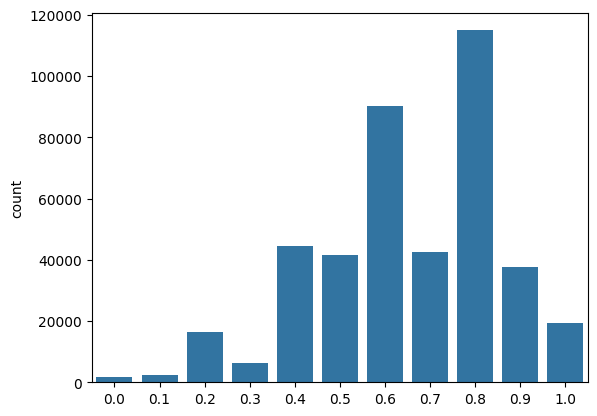

In [13]:
dd = df["Score"].value_counts().sort_index()
dd_indexes = np.array(dd.index.tolist())
sns.barplot(x=dd_indexes, y=dd)
print(dd)

<Axes: ylabel='count'>

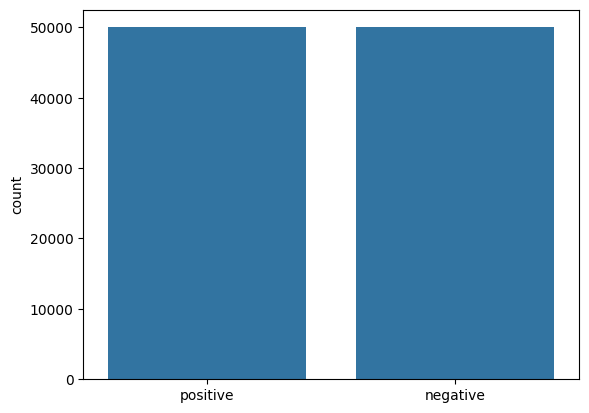

In [14]:
positive_reviews_slice = df[df.Score >= 0.9]
negative_reviews_slice = df[df.Score <= 0.4]

# Resample them to 50k samples each for balance
positive_reviews_slice = resample(
    positive_reviews_slice, replace=False, n_samples=50000, random_state=123
)
negative_reviews_slice = resample(
    negative_reviews_slice, replace=False, n_samples=50000, random_state=123
)

dd_slice = pd.concat([positive_reviews_slice, negative_reviews_slice])
dd_slice["Score"] = np.where(dd_slice["Score"] <= 0.4, "negative", "positive")

dd_slice_indexes = np.array(dd_slice["Score"].value_counts().index.tolist())
sns.barplot(x=dd_slice_indexes, y=dd_slice["Score"].value_counts())

In [15]:
df = dd_slice

X, y = df["Review"].values, df["Score"].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(f"\nShape of the train data is {x_train.shape}")
print(f"\nShape of the test data is {x_test.shape}")
df.head()


Shape of the train data is (75000,)

Shape of the test data is (25000,)


,Unnamed: 0,Movie,Reviewer,Publish,Review,Date,Score
319931,320963,MONEYBALL,Michael Phillips,Chicago Tribune,"Everything in Beane's story and in ""Moneyball""...",22/09/2011,positive
384687,387491,A CHRISTMAS TALE,Jeff Shannon,Seattle Times,There are simply too many marvels to tally.,21/11/2008,positive
180858,181010,EDEN,Scott Renshaw,Salt Lake City Weekly,Eden winds and meanders through its 21-year co...,10/07/2015,positive
101059,101111,PHANTOM THREAD,Brad Keefe,Columbus Alive,"As anyone would expect, Day-Lewis gives a perf...",25/01/2018,positive
246616,246960,12 YEARS A SLAVE,Steven Rea,Philadelphia Inquirer,It speaks to the courage and resilience of one...,13/01/2015,positive


In [21]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", "", s)
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"\d", "", s)

    return s


def tokenize(x_train,y_train,x_val,y_val):
    # load pre-trained word vectors
    glove = vocab.GloVe(name='6B', dim=100)

    # tokenize and encode sentences
    final_list_train, final_list_test = [], []
    for sent in x_train:
        encoded_sent = []
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word in glove.stoi:
                encoded_sent.append(glove.stoi[word])
        final_list_train.append(encoded_sent)

    for sent in x_val:
        encoded_sent = []
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word in glove.stoi:
                encoded_sent.append(glove.stoi[word])
        final_list_test.append(encoded_sent)

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train, dtype=object), np.array(encoded_train), np.array(final_list_test, dtype=object), np.array(encoded_test), glove.stoi

In [ ]:
x_train, y_train, x_test, y_test, vocab = tokenize(x_train, y_train, x_test, y_test)

In [12]:
print(f"\nLength of vocabulary is {len(vocab)}")


Length of vocabulary is 400000


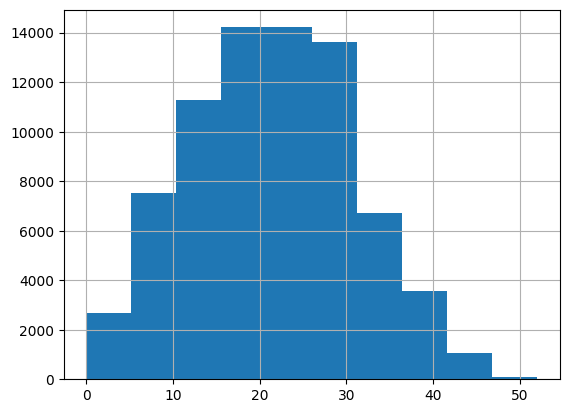

count    75000.000000
mean        21.403227
std          9.370613
min          0.000000
25%         14.000000
50%         21.000000
75%         28.000000
max         52.000000
dtype: float64

In [13]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [14]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review) :] = np.array(review)[:seq_len]
    return features

In [15]:
x_train_pad = padding_(x_train, 52)
x_test_pad = padding_(x_test, 52)

In [16]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# Dataloaders
batch_size = 50

train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)
valid_loader = DataLoader(
    valid_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [17]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print("Sample input size: ", sample_x.size())
print("Sample input: \n", sample_x)
print("Sample input: \n", sample_y)

Sample input size:  torch.Size([50, 52])
Sample input: 
 tensor([[    0,     0,     0,  ...,     7, 87543, 44353],
        [    0,     0,     0,  ...,    47,    96, 24475],
        [    0,     0,     0,  ...,    12,    20,  5487],
        ...,
        [    0,     0,     0,  ..., 70151,     5, 52720],
        [    0,     0,     0,  ...,    73,     7, 16035],
        [    0,     0,     0,  ...,  1942,     3, 51404]])
Sample input: 
 tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0])


In [18]:
class SentimentRNN(nn.Module):
    def __init__(
        self,
        no_layers,
        vocab_size,
        hidden_dim,
        embedding_dim,
        drop_prob=0.5,
        bidirectional=False,
    ):
        super(SentimentRNN, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=no_layers,
            batch_first=True,
        )

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]  # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [19]:
no_layers = 2
vocab_size = len(vocab) + 1  # extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(
    no_layers=no_layers,
    vocab_size=vocab_size,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    drop_prob=0.5,
)

# Moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(400001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [22]:
import os

In [23]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f"Epoch {epoch+1}")
    print(f"train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}")
    print(f"train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}")

    if epoch_val_loss <= valid_loss_min:
        os.makedirs("../working", exist_ok=True)
        torch.save(model.state_dict(), "model.pt")
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, epoch_val_loss
            )
        )
        valid_loss_min = epoch_val_loss
    print(25 * "==")

Epoch 1
train_loss : 0.3121897722631693 val_loss : 0.3361285789757967
train_accuracy : 86.58133333333333 val_accuracy : 85.036
Validation loss decreased (inf --> 0.336129).  Saving model ...
Epoch 2
train_loss : 0.22577684190124273 val_loss : 0.3315448680520058
train_accuracy : 90.73733333333334 val_accuracy : 86.112
Validation loss decreased (0.336129 --> 0.331545).  Saving model ...
Epoch 3
train_loss : 0.15529379893715184 val_loss : 0.36730658046901227
train_accuracy : 94.00133333333333 val_accuracy : 86.10799999999999
Epoch 4
train_loss : 0.09214510838873684 val_loss : 0.45229915104806423
train_accuracy : 96.596 val_accuracy : 85.88
Epoch 5
train_loss : 0.05029123119738264 val_loss : 0.578817652925849
train_accuracy : 98.252 val_accuracy : 85.452


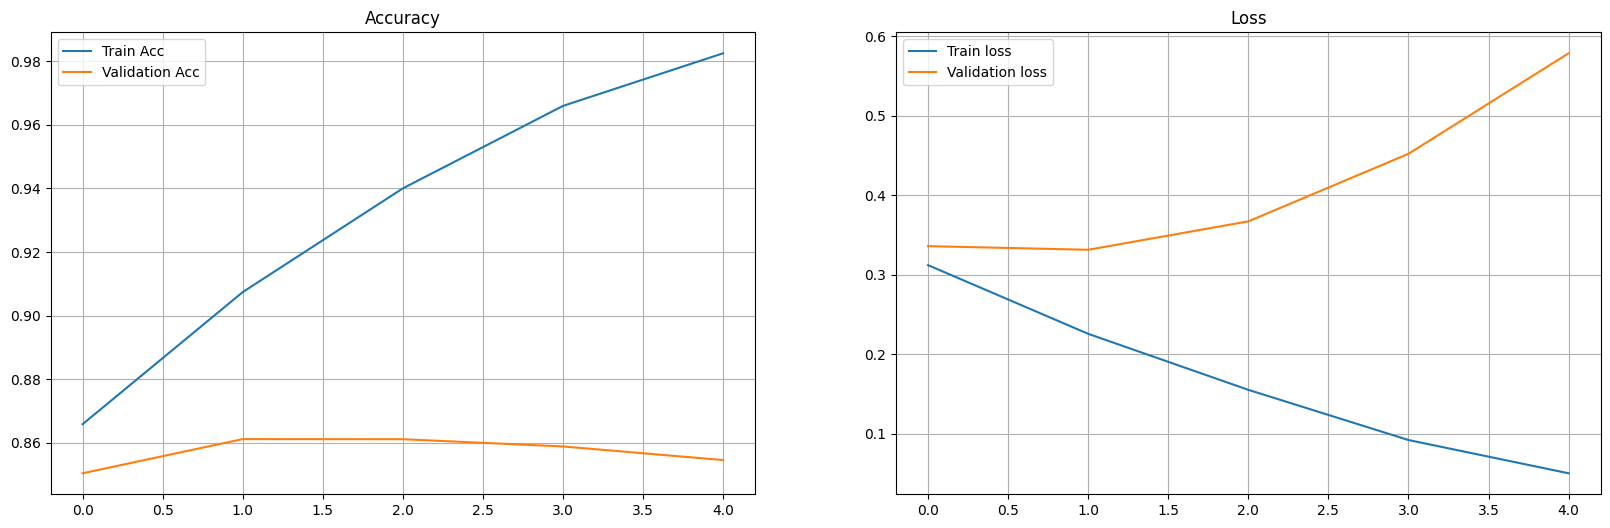

In [24]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [25]:
def predict_text(text):
    word_seq = np.array(
        [
            vocab[preprocess_string(word)]
            for word in text.split()
            if preprocess_string(word) in vocab.keys()
        ]
    )
    word_seq = np.expand_dims(word_seq, axis=0)
    pad = torch.from_numpy(padding_(word_seq, 500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return output.item()

In [26]:
test_str = "I really am appaled by the brokenness of this movie"
print(test_str)
print("=" * 70)
pro = predict_text(test_str)
status = "positive" if pro >= 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f"Predicted sentiment is {status} with a probability of {pro}")

I really am appaled by the brokenness of this movie
Predicted sentiment is negative with a probability of 0.7012264728546143


In [27]:
import pickle

# Save the vocabulary
with open('../working/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [28]:
from google.colab import files

# Download the files
files.download("model.pt")
files.download("vocab.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>